
# **TP 3 — Aprendizaje No Supervisado (Clustering de Países)**

Este trabajo práctico implementa un **proceso KDD completo** (Limpieza → Integración → Selección → Transformación → Minería & Evaluación) para **agrupar países** según indicadores socioeconómicos usando **K-Means**.  
Se sigue la **misma estructura, estilo y comentarios** utilizada en los TPs anteriores (clasificación y regresión).


In [266]:
## AUXILIAR: IMPORTS GLOBALES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [267]:
## AUXILIAR: Reporte de clustering y funciones de apoyo.

"""
Muestra métricas internas típicas para clustering (sin etiquetas verdaderas):
- Silhouette (cuanto más alto mejor, ~0.5-0.7 muy bueno)
- Calinski-Harabasz (más alto mejor)
- Davies-Bouldin (más bajo mejor)
"""

def show_results(modelo, atributos_escalados, clusters_asignados, title):
    print(f"\n{title}:")
    print(f"Inertia (SSE)                      : {modelo.inertia_:.2f}")
    print(f"Silhouette Score                   : {silhouette_score(atributos_escalados, clusters_asignados):.4f}")
    print(f"Davies-Bouldin Index (DBI) Score   : {davies_bouldin_score(atributos_escalados, clusters_asignados):.4f}")
    print(f"Calinski-Harabasz Index (CHI) Score: {calinski_harabasz_score(atributos_escalados, clusters_asignados):.4f}")

In [268]:
## AUXILIAR: Graficar dispersión de los clusters

"""
El método genera un gráfico de dispersión 2D aplicando PCA (Análisis de Componentes Principales).
PCA toma todas las variables numéricas (ya escaladas) y crea dos nuevas variables:
- Componente principal 1 (PC1)
- Componente principal 2 (PC2)
Estas dos variables resumen la mayor parte de la información del dataset, y ayudan
a representar en un plano 2D los distintos clusters generados.
"""

def graficar_dispersion(atributos_escalados, clusters_asignados, title):
    pca = PCA(n_components=2, random_state=42)
    X_2d = pca.fit_transform(atributos_escalados)
    
    plt.figure(figsize=(7,5))
    plt.scatter(X_2d[:,0], X_2d[:,1], c=clusters_asignados)
    plt.title(title)
    """ plt.xlabel(f"Componente principal 1 ({(pca.explained_variance_ratio_[0] * 100):.2f}%)") """
    """ plt.ylabel(f"Componente principal 2 ({(pca.explained_variance_ratio_[1] * 100):.2f}%)") """
    plt.grid(True)
    plt.show()

In [269]:
## AUXILIAR: Graficar análisis de métricas dependiendo el valor de K

def graficar_inertia_por_k(k_values, inertias): # Elbow method
    plt.figure(figsize=(7,4))
    plt.plot(k_values, inertias, marker='o')
    plt.title("Inertia por K (Elbow method) (↓ más bajo es mejor)")
    plt.xlabel("K (número de clusters)")
    plt.ylabel("Inertia")
    plt.grid(True)
    plt.show()

def graficar_silhouette_por_k(k_values, silhouettes):
    plt.figure(figsize=(7,4))
    plt.plot(k_values, silhouettes, marker='o')
    plt.title("Silhouette por K (↑ más alto es mejor)")
    plt.xlabel("K (número de clusters)")
    plt.ylabel("Silhouette")
    plt.grid(True)
    plt.show()

def graficar_dbi_por_k(k_values, dbi_scores):
    plt.figure(figsize=(10,4))
    plt.plot(k_values, dbi_scores, marker='o')
    plt.title("DBI por K (↓ más bajo es mejor)")
    plt.xlabel("K (número de clusters)")
    plt.ylabel("DBI")
    plt.grid(True)
    plt.show()

def graficar_chi_por_k(k_values, chi_scores):
    plt.figure(figsize=(10,4))
    plt.plot(k_values, chi_scores, marker='o')
    plt.title("CHI por K (↑ más alto es mejor)")
    plt.xlabel("K (número de clusters)")
    plt.ylabel("CHI")
    plt.grid(True)
    plt.show()

In [270]:
# Carga de datos
dataset = pd.read_csv('../datasets/countries.csv')


#### LIMPIEZA
Se revisan tipos, nulos y duplicados para asegurar consistencia del dataset.

- Varias columnas numéricas vienen como *string* con coma decimal → se normalizan a `float`.
- Se imputan numéricas con **mediana** (robusta a outliers) para no perder filas.
- Columnas con demasiados nulos o de baja utilidad (p. ej. `Climate`) podrán eliminarse.


In [271]:
# Análisis Exploratorio.

print("\nInfo general del dataset:")
dataset.head()
dataset.info()

print("\nValores faltantes por atributo:")
print(dataset.isnull().sum().sort_values(ascending=False))

print("\nFilas duplicadas:")
print(dataset.duplicated().sum())


Info general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Country                             227 non-null    object 
 1   Region                              227 non-null    object 
 2   Population                          227 non-null    int64  
 3   Area (sq. mi.)                      227 non-null    int64  
 4   Pop. Density (per sq. mi.)          227 non-null    object 
 5   Coastline (coast/area ratio)        227 non-null    object 
 6   Net migration                       224 non-null    object 
 7   Infant mortality (per 1000 births)  224 non-null    object 
 8   GDP ($ per capita)                  226 non-null    float64
 9   Literacy (%)                        209 non-null    object 
 10  Phones (per 1000)                   223 non-null    object 
 11  Arable (%)        

In [272]:
# Se detectan las columnas numéricas que vienen como texto con comas y se transforman a float
def transform_object_to_float(columna: pd.Series):
    if columna.dtype == 'object':
        # Reemplazar coma por punto.
        columna = columna.str.replace(',', '.')
        # Convierte a valor numérico (float64).
        columna = pd.to_numeric(columna)

        return columna
    
    return columna

for columna in dataset.columns:
    if (columna != 'Country' and columna != 'Region'):
        dataset[columna] = transform_object_to_float(dataset[columna])

print("\nTipos de datos tras normalización de decimales:")
print(dataset.dtypes)


Tipos de datos tras normalización de decimales:
Country                                object
Region                                 object
Population                              int64
Area (sq. mi.)                          int64
Pop. Density (per sq. mi.)            float64
Coastline (coast/area ratio)          float64
Net migration                         float64
Infant mortality (per 1000 births)    float64
GDP ($ per capita)                    float64
Literacy (%)                          float64
Phones (per 1000)                     float64
Arable (%)                            float64
Crops (%)                             float64
Other (%)                             float64
Climate                               float64
Birthrate                             float64
Deathrate                             float64
Agriculture                           float64
Industry                              float64
Service                               float64
dtype: object


In [273]:
# Imputación.

""" 
Se proceden a imputar los valores nulos de los atributos del dataset.
- Para atributos continuos, se utilizará la mediana.
"""

# Columnas numéricas.
numeric_cols = dataset.drop(columns=['Country', 'Region']).columns.tolist()

for columna in numeric_cols:
    mediana = dataset[columna].median()
    dataset[columna] = dataset[columna].fillna(mediana)

# Verificación.
print("\nValores faltantes por atributo:")
print(dataset.isnull().sum())


Valores faltantes por atributo:
Country                               0
Region                                0
Population                            0
Area (sq. mi.)                        0
Pop. Density (per sq. mi.)            0
Coastline (coast/area ratio)          0
Net migration                         0
Infant mortality (per 1000 births)    0
GDP ($ per capita)                    0
Literacy (%)                          0
Phones (per 1000)                     0
Arable (%)                            0
Crops (%)                             0
Other (%)                             0
Climate                               0
Birthrate                             0
Deathrate                             0
Agriculture                           0
Industry                              0
Service                               0
dtype: int64


#### INTEGRACIÓN
No se requirió integración: el análisis se realizó con un único CSV consistente.

Si en el futuro se incorporan varias fuentes, acá se resolvía el join y la reconciliación de claves.



#### SELECCIÓN
Se seleccionan atributos numéricos representativos del nivel de desarrollo para el clustering, evitando redundancias fuertes.

**Candidatos principales** (presentes en el CSV típico de países):
- `GDP ($ per capita)`, `Literacy (%)`, `Phones (per 1000)`, `Infant mortality (per 1000 births)`, `Birthrate`, `Deathrate`,
- `Agriculture`, `Industry`, `Service`, `Population` (opcional — puede sesgar por escala, se prueba y se decide).

Se excluyen campos estrictamente identificatorios (`Country`, `Region`) del entrenamiento (se usan para análisis/rotulado posterior).


In [274]:
# Selección de columnas a usar para clustering
columnas_seleccionadas = [
    'Net migration', # Países en desarrollo tienen más migración, países no en desarrollo tienen menos migración.
    'Infant mortality (per 1000 births)', # Mortalidad infantil.
    'GDP ($ per capita)', # Indicador económico.
    'Literacy (%)', # Porcentaje de alfabetización.
    'Phones (per 1000)', # Nivel de infra tecnológica.
    'Birthrate', # Tasa de nacimiento.
    'Agriculture', # PBI Proveniente de agro, si es alta es que hay baja industrialización.
    'Industry', # Nivel de sector industrial.
    'Service' # Nivel de sector de servicios, en países desarrollados suele es alta.
]

# Atributos para el modelo
atributos_seleccionados = dataset[columnas_seleccionadas].copy()

# Validar selección
atributos_seleccionados.head()

,Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Birthrate,Agriculture,Industry,Service
0,23.06,163.07,700.0,36.0,3.2,46.60,0.380,0.240,0.380
1,-4.93,21.52,4500.0,86.5,71.2,15.11,0.232,0.188,0.579
2,-0.39,31.00,6000.0,70.0,78.1,17.14,0.101,0.600,0.298
3,-20.71,9.27,8000.0,97.0,259.5,22.46,0.099,0.272,0.571
4,6.60,4.05,19000.0,100.0,497.2,8.71,0.099,0.272,0.571



#### TRANSFORMACIÓN
Se convierte el dato al formato que requieren los algoritmos de distancia:
- **Escalado con `StandardScaler()`** de los atributos continuos (solo dentro del pipeline para evitar *data leakage*).
- Opcionalmente se evaluará el efecto de **incluir/excluir `Population`** por su magnitud.


In [275]:
"""
Se aplica un escalado con StandardScaler() para los atributos continuos.
Este escalado se aplica en el training set al momento de hacer el split, y no
en todo el dataset dado que provoca filtración de data y eso puede sesgar las métricas
de los modelos (el test set gana información sobre el training set que no debería saber).
"""

'\nSe aplica un escalado con StandardScaler() para los atributos continuos.\nEste escalado se aplica en el training set al momento de hacer el split, y no\nen todo el dataset dado que provoca filtración de data y eso puede sesgar las métricas\nde los modelos (el test set gana información sobre el training set que no debería saber).\n'


#### MINERÍA Y EVALUACIÓN
Se aplican varias **iteraciones** análogas al estilo de los TPs anteriores:

- **Iteración 1:** K-Means con k=3 (baseline) → métricas internas y PCA 2D.
- **Iteración 2:** Búsqueda de *k* (grid de 2 a 8) con curva del codo (inertia) y *silhouette* para elegir k.
- **Iteración 3:** K-Means con *k* óptimo → métricas finales, visualización PCA y **perfilado de clusters** (medianas por cluster en escala original).


In [276]:
## K-MEANS:

""" 
Se genera un pipeline el cual procura que el modelo ESCALE los valores continuos
SOLO en cada respectivo training set, esto evita que haya filtrado de data en el
test set y el modelo dé métricas un poco sesgadas.
"""

pipe_KM = Pipeline([
    ("continuos", StandardScaler()),
    ("modelo", KMeans(n_clusters=3, random_state=42, n_init='auto'))
])


K-Means (k=3):
Inertia (SSE)                      : 975.31
Silhouette Score                   : 0.2863
Davies-Bouldin Index (DBI) Score   : 1.1835
Calinski-Harabasz Index (CHI) Score: 122.6095


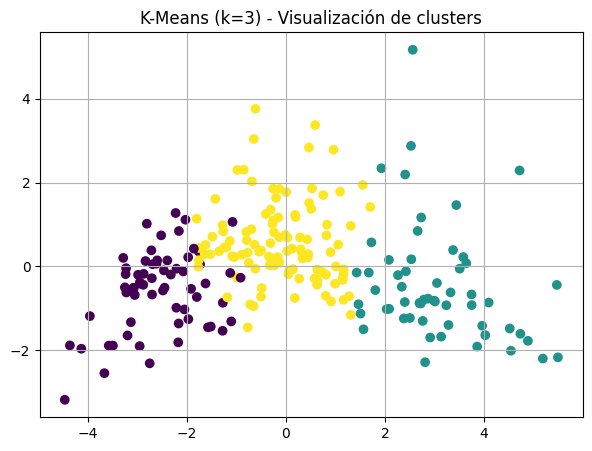

In [277]:
## Primera iteración: K-Means (k=3)

# Entrenar modelo y obtener la columna con los clusters asignados a cada fila
clusters_asignados = pipe_KM.fit_predict(atributos_seleccionados)

atributos_escalados = pipe_KM.named_steps['continuos'].transform(atributos_seleccionados)
modelo = pipe_KM.named_steps['modelo']

# Evaluar resultados
show_results(modelo, atributos_escalados, clusters_asignados, title=f"K-Means (k=3)")

# Evaluar gráficamente
graficar_dispersion(atributos_escalados, clusters_asignados, title=f"K-Means (k=3) - Visualización de clusters")

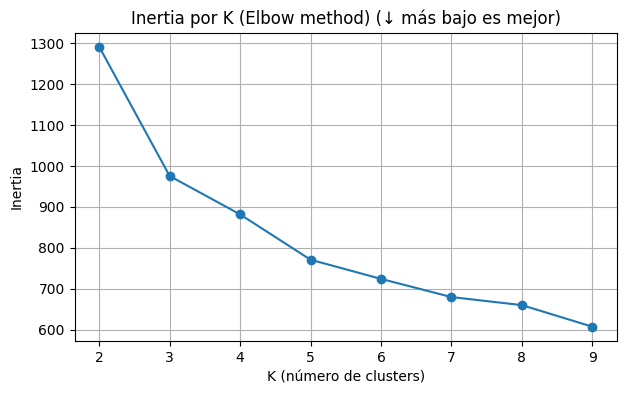

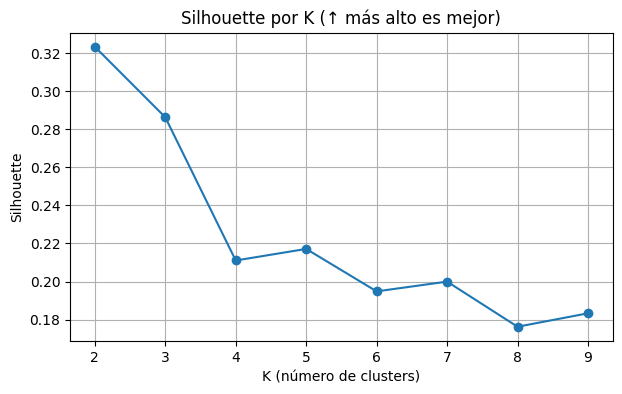

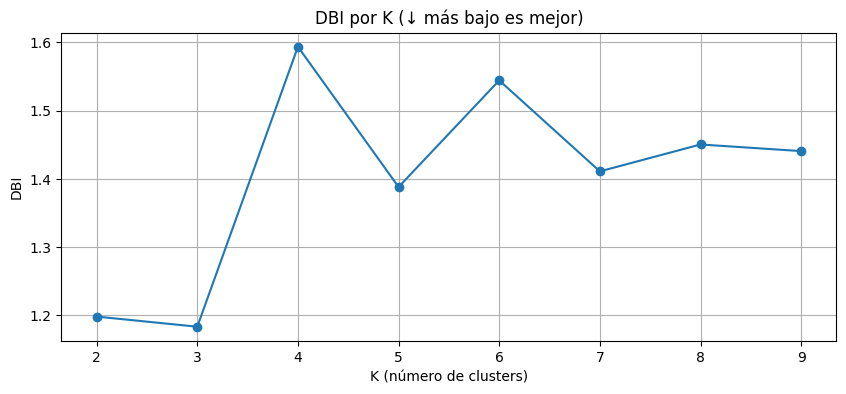

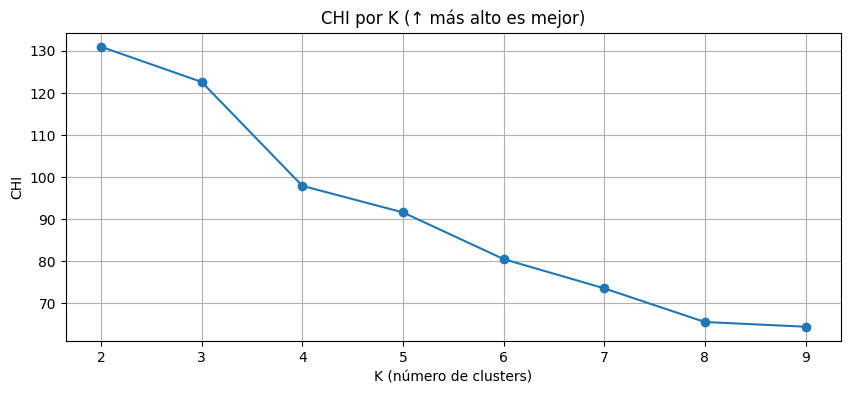

In [278]:
## Segunda iteración: K-Means + Análisis de K ideal

# Valores K a testear
k_values = [2, 3, 4, 5, 6, 7, 8, 9]

# Métricas
inertias = []
silhouettes = []
dbi_scores = []
chi_scores = []

for k in k_values:
    pipe_KM = Pipeline([
        ("continuos", StandardScaler()),
        ("modelo", KMeans(n_clusters=k, random_state=42, n_init='auto'))
    ])

    clusters_asignados = pipe_KM.fit_predict(atributos_escalados)
    atributos_escalados = pipe_KM.named_steps['continuos'].transform(atributos_escalados)
    
    modelo = pipe_KM.named_steps['modelo']

    inertias.append(modelo.inertia_)
    silhouettes.append(silhouette_score(atributos_escalados, clusters_asignados))
    dbi_scores.append(davies_bouldin_score(atributos_escalados, clusters_asignados))
    chi_scores.append(calinski_harabasz_score(atributos_escalados, clusters_asignados))

# Evaluar resultados gráficamente
graficar_inertia_por_k(k_values, inertias)
graficar_silhouette_por_k(k_values, silhouettes)
graficar_dbi_por_k(k_values, dbi_scores)
graficar_chi_por_k(k_values, chi_scores)


K-Means K óptimo (k=2):
Inertia (SSE)                      : 1291.29
Silhouette Score                   : 0.3234
Davies-Bouldin Index (DBI) Score   : 1.1983
Calinski-Harabasz Index (CHI) Score: 130.9823


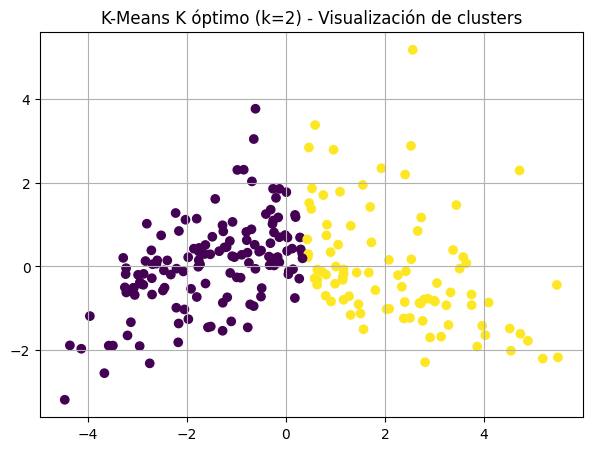

In [279]:
## Continuación de segunda iteración: K-Means + Análisis de K ideal

k_optimo = 2

pipe_KM = Pipeline([
    ("continuos", StandardScaler()),
    ("modelo", KMeans(n_clusters=k_optimo, random_state=42, n_init='auto'))
])

# Entrenar modelo y obtener la columna con los clusters asignados a cada fila
clusters_asignados = pipe_KM.fit_predict(atributos_escalados)

atributos_escalados = pipe_KM.named_steps['continuos'].transform(atributos_escalados)
modelo = pipe_KM.named_steps['modelo']

# Evaluar resultados
show_results(modelo, atributos_escalados, clusters_asignados, title=f"K-Means K óptimo (k={k_optimo})")

# Evaluar gráficamente
graficar_dispersion(atributos_escalados, clusters_asignados, title=f"K-Means K óptimo (k={k_optimo}) - Visualización de clusters")

In [282]:
# Perfilado de clusters: medianas por cluster en escala original

# Se agrega una nueva columna a los atributos seleccionados con los valores agrupados por el modelo
atributos_seleccionados['cluster'] = clusters_asignados

# Separar en grupos clasificados por el tipo de cluster
    # Cada grupo es un dataset que contiene filas con el mismo tipo de cluster
grupos = atributos_seleccionados.groupby('cluster')

# Calcular la mediana de cada atributo dentro de cada grupo
medianas_por_cluster = grupos.median()
promedios_por_cluster = grupos.mean()

print("\nValores en promedio por cluster:\n")
print(medianas_por_cluster)


Valores en promedio por cluster:

         Net migration  Infant mortality (per 1000 births)  \
cluster                                                      
0                  0.0                                9.95   
1                  0.0                               67.24   

         GDP ($ per capita)  Literacy (%)  Phones (per 1000)  Birthrate  \
cluster                                                                   
0                   11400.0          96.0              310.3     14.005   
1                    1700.0          68.9               23.7     32.780   

         Agriculture  Industry  Service  
cluster                                  
0             0.0545    0.2725   0.6415  
1             0.2370    0.2420   0.4300  


In [ ]:
""" # Adjuntar países y región a los grupos de clusters.
identificadores = dataset[['Country', 'Region']].copy()

if identificadores is not None:
    asignaciones = pd.concat([identificadores.reset_index(drop=True), atributos_seleccionados['cluster'].reset_index(drop=True)], axis=1)
    print("\nMuestras de países por cluster:\n")
    
    for c in sorted(atributos_seleccionados['cluster'].unique()):
        subset = asignaciones[asignaciones['cluster'] == c].head(10)
        print(f"Cluster {c} -> {len(asignaciones[asignaciones['cluster'] == c])} países (muestra):")
        print(subset[['Country','Region','cluster']].head(10))
        print("-") """

' # (Opcional) Adjuntar Country/Region para inspección rápida de pertenencia de cada país\nidentificadores = dataset[[\'Country\', \'Region\']].copy()\n\nif identificadores is not None:\n    asignaciones = pd.concat([identificadores.reset_index(drop=True), atributos_seleccionados[\'cluster\'].reset_index(drop=True)], axis=1)\n    print("\nMuestras de países por cluster:\n")\n\n    for c in sorted(atributos_seleccionados[\'cluster\'].unique()):\n        subset = asignaciones[asignaciones[\'cluster\'] == c].head(10)\n        print(f"Cluster {c} -> {len(asignaciones[asignaciones[\'cluster\'] == c])} países (muestra):")\n        print(subset[[\'Country\',\'Region\',\'cluster\']].head(10))\n        print("-") '

### Conclusiones

El modelo K-Means (K = 2) logró segmentar los países en dos grupos bien diferenciados.

El primer grupo representa economías más desarrolladas, con altos ingresos, alta alfabetización y mayor sector de servicios.  
El segundo grupo agrupa países en desarrollo o de bajos ingresos, con alta natalidad, mortalidad infantil elevada y más dependencia del sector agrícola.

Las métricas de evaluación muestran una separación razonable entre los grupos, confirmando que las variables seleccionadas fueron adecuadas para describir el nivel de desarrollo de cada país.
